In [2]:
import pandas as pd
import streamlit as st
import sklearn
import numpy as np
import csv
import json
import matplotlib.pyplot as plt

In [23]:
#CSVs einlesen und DataFrames bauen. Weirde Spalten löschen und ne richtige Zeite Spalte hinzufügen

path = r"C:\Users\ReneJ\Desktop\Data"

light = pd.read_csv(path+ r"\2023-04-22_08-09-30\Light.csv")
displayB = pd.read_csv(path + r"\2023-04-22_08-09-30\Brightness.csv")
battery = pd.read_csv(path + r"\2023-04-22_08-09-30\Battery.csv")
location = pd.read_csv(path + r"\2023-04-22_08-09-30\Location.csv")

dfs =[light, displayB, battery, location]

light["Time"] = pd.to_datetime(light['time'], unit = 'ns')
light.drop(columns=["time", "seconds_elapsed"])

displayB["Time"] = pd.to_datetime(displayB["time"], unit = 'ns')
displayB.drop(columns=["time", "seconds_elapsed"])

battery["Time"] = pd.to_datetime(battery['time'], unit = 'ns')
battery.drop(columns=["time", "seconds_elapsed"])

location["Time"] = pd.to_datetime(location['time'], unit = 'ns')
location.drop(columns=["time", "seconds_elapsed"])

type(location["Time"][0])
location["Time"][0].to_pydatetime()


for df in dfs:
    df["Readable_Time"] = df["Time"]
    for i in range(0,len(df["Time"])):
        df["Readable_Time"][i] = df["Time"][i].to_pydatetime()

light


C:\Users\ReneJ\AppData\Local\Temp\ipykernel_24704\2091383385.py:31: UserWarning: Discarding nonzero nanoseconds in conversion.
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_24704\2091383385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_24704\2091383385.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Readable_Time"][i] = df["Time"][i].to_pydatetime()
C:\Users\ReneJ\AppData\Local\Temp\ipykernel_24704\2091383385.py:31: SettingWithCopyWarning: 
A value is 

,time,seconds_elapsed,lux,Time,Readable_Time
0,1682150970343186200,-0.031814,361,2023-04-22 08:09:30.343186200,2023-04-22 08:09:30.343186
1,1682150970600927200,0.225927,361,2023-04-22 08:09:30.600927200,2023-04-22 08:09:30.600927
2,1682150970721837800,0.346838,363,2023-04-22 08:09:30.721837800,2023-04-22 08:09:30.721837
3,1682150970782262800,0.407263,365,2023-04-22 08:09:30.782262800,2023-04-22 08:09:30.782262
4,1682150970842687500,0.467687,363,2023-04-22 08:09:30.842687500,2023-04-22 08:09:30.842687
...,...,...,...,...,...
130200,1682205732018796500,54761.643797,9,2023-04-22 23:22:12.018796500,2023-04-22 23:22:12.018796
130201,1682205732200101600,54761.825102,6,2023-04-22 23:22:12.200101600,2023-04-22 23:22:12.200101
130202,1682205732639890400,54762.264890,9,2023-04-22 23:22:12.639890400,2023-04-22 23:22:12.639890
130203,1682205732821958100,54762.446958,11,2023-04-22 23:22:12.821958100,2023-04-22 23:22:12.821958


<Axes: xlabel='Time'>

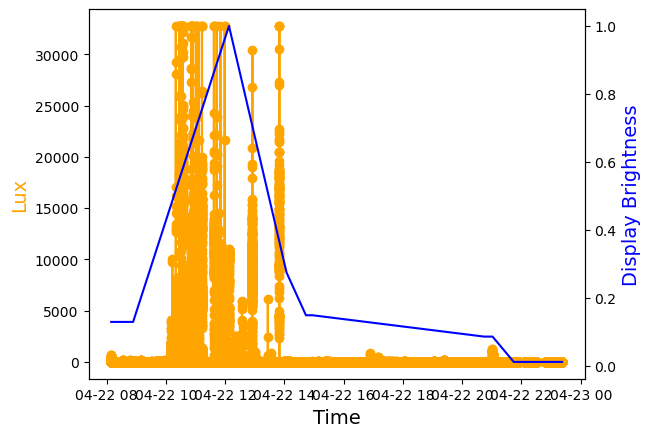

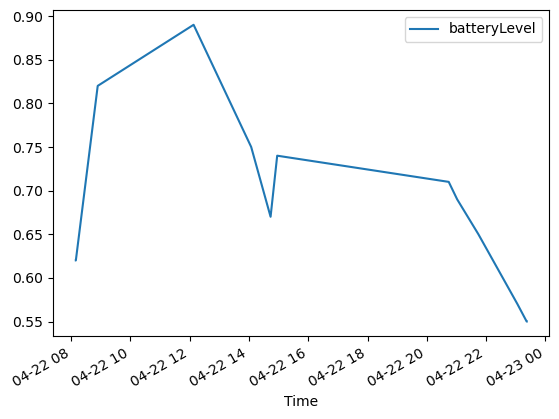

In [27]:
#light.plot(x= "Time", y = "lux")
#displayB.plot(x = "Time", y = "brightness")


fig = plt.subplot()
ax = plt.subplot()
ax.plot(light["Readable_Time"], light["lux"], color = "orange", marker = "o")
ax.set_xlabel("Time", fontsize = 14)
ax.set_ylabel("Lux", color = "orange", fontsize = 14)

ax2 = ax.twinx()
ax2.plot(displayB["Readable_Time"], displayB["brightness"], color = "blue")
ax2.set_ylabel("Display Brightness", color = "blue", fontsize = 14)

plt.show

battery.plot(x = "Time", y = "batteryLevel")